In [133]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.autograd.functional as AF
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

# Fixed point for myosin intensity

In [126]:
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['font.size'] = 6
plt.rcParams['figure.dpi'] = 200

np.set_printoptions(precision=3, suppress=True)

def first_N_harmonics(f, N=1):
    qx = np.fft.fftfreq(f.shape[-1], d=1/f.shape[-1])
    qy = np.fft.fftfreq(f.shape[-2], d=1/f.shape[-2])
    q = np.stack(np.meshgrid(qy, qx, indexing='ij'))
    q = np.linalg.norm(q, axis=0)
    
    x = np.fft.fftshift(f, axes=(-2, -1))
    q = np.fft.fftshift(q, axes=(-2, -1))
    bounds = np.argwhere(q <= N)
    i0 = np.min(bounds[:, 0])
    i1 = np.max(bounds[:, 0])
    j0 = np.min(bounds[:, 1])
    j1 = np.max(bounds[:, 1])
    return x[i0:i1+1, j0:j1+1][::-1, :] #Origin lower

def unshift(f, cutoff=1e-3):
    x = np.abs(f)**2
    x[x < cutoff * np.max(f)] = 0
    x = np.fft.fftshift(x, axes=(-2, -1))
    x = np.log(x)
    x[x == -np.inf] = np.nan
    return x

Cadherin
[[0.1 0.  0.1]
 [0.  1.2 0. ]
 [0.1 0.  0.1]]

Myosin
[[-0.03 -0.   -0.03]
 [-0.    0.14 -0.  ]
 [-0.03 -0.   -0.03]]
m_yy(0, 0) = -A (1 - k c0) / B:	 True
m_yy(±1, ±1) = k A c1 / 4 B:	 True

RHS is zero:  True


Text(0.5, 1.0, '$A[1 - k c] m + B m^2$')

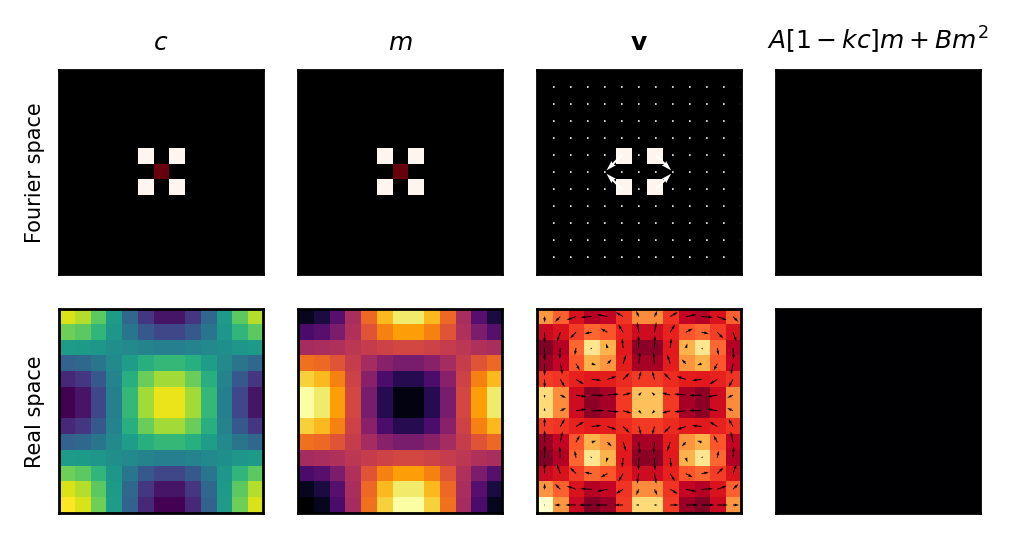

In [150]:
N = 13
half = N//2
qx = np.fft.fftfreq(N, 1/N)
qy = np.fft.fftfreq(N, 1/N)
qi = np.stack(np.meshgrid(qx, qy, indexing='ij'))
q = np.linalg.norm(qi, axis=0)

#Define parameters
alpha = 3
mu = 1
am = alpha / mu
A, B, k = 1, -1, 0.6
A, B = 1/3., -2/3.

cmap = plt.cm.Reds
cmap.set_bad('black')
kwargs = dict(cmap=cmap, extent=[qx.min(), qx.max(), qy.min(), qy.max()])
plt.cm.Reds.set_bad('black')
fig, ax = plt.subplots(2, 4, dpi=250, figsize=(4, 2))
for a in ax.flatten(): a.set(xticks=[], yticks=[])
ax[0, 0].set_ylabel('Fourier space')
ax[1, 0].set_ylabel('Real space')
plt.tight_layout()

#Define cadherin field
cq = np.zeros([N, N])
c0, c1 = 1.2, 0.4
cq[ 0,  0] = c0
cq[ 1,  1] = c1 / 4
cq[ 1, -1] = c1 / 4
cq[-1,  1] = c1 / 4
cq[-1, -1] = c1 / 4
c = np.fft.ifft2(cq).real * N**2

print('Cadherin')
print(first_N_harmonics(cq, N=1).real)

ax[0, 0].imshow(unshift(cq), **kwargs)
ax[1, 0].imshow(c, cmap='viridis')
ax[0, 0].set_title(r'$c$')

#Myosin fixed point
mq = A / B * k * cq
mq[0, 0] -= A / B
m = np.fft.ifft2(mq).real * N**2

print('\nMyosin')
print(first_N_harmonics(mq, N=1).real)
print('m_yy(0, 0) = -A (1 - k c0) / B:\t', np.allclose(mq[0, 0], -A/B * (1 - k * c0))) 
print('m_yy(±1, ±1) = k A c1 / 4 B:\t', np.allclose(mq[1, 1], k * A * c1 / (4 * B)))

ax[0, 1].imshow(unshift(mq), **kwargs)
ax[1, 1].imshow(m, cmap='inferno')
ax[0, 1].set_title(r'$m$')

#Compute corresponding flow
vq     = -qi * qi[0]**2 / q**4
vq[0] += qi[0] / q**2
vq    = 1j * am * mq * vq.astype(np.complex128)
vq[:, 0, 0] = 0
vi = np.fft.ifft2(vq).real * N**2

ax[0, 2].imshow(unshift(vq[0]), **kwargs)
ax[0, 2].quiver(qi[1], qi[0], vq[1].imag, vq[0].imag, 
                color='white', scale=3e-1, width=0.01)
ax[1, 2].quiver(vi[1], vi[0])
ax[1, 2].imshow(np.linalg.norm(vi, axis=0), cmap='YlOrRd')
ax[0, 2].set_title(r'$\mathbf{v}$')

# Show RHS is zero
rhs = A * (1 - k * c) * m + B * m**2
rhsq = np.fft.fft2(rhs)

print('\nRHS is zero: ', np.allclose(rhsq, 0))
ax[0, 3].imshow(unshift(rhsq), **kwargs)
ax[1, 3].imshow(rhs, cmap='inferno', vmin=0, vmax=np.max(m))
ax[0, 3].set_title(r'$A[1 - k c] m + B m^2$')

# Can we find a fixed point for the orientation?

In the above, the orientation angle is un-determined, and without including co-rotation or convection, it remains undetermined. If we include co-rotation, which does not affect the myosin intensity at each point, is there a unique fixed point for this equation?

The dynamics for the orientation angle $\theta$ reduce to
\begin{equation}
    \partial_t \theta + \frac{1}{2} \nabla^2 \psi = 0
\end{equation}

The stream function $\psi$, defined as $v_i = \epsilon_{ij} \nabla_j \psi$, must then be a harmonic function. It is generically given by a bi-harmonic equation

\begin{equation}
    \nabla^4 \psi = \frac{\alpha}{\mu} \left[
        \frac{1}{2} (\nabla_x^2 - \nabla_y^2) m \sin 2\theta - \nabla^2_{xy} m \cos 2\theta
    \right]
\end{equation}

For the constraint $\nabla^2 \psi = 0$ to be satisfied, we must also have that $\nabla^4 \psi = 0$, and so the right-hand side of the above must cancel. The intensity $m$ is already fixed, however, with $m = m_0 = -\frac{A}{B} (1 - k c)$. To find the $\theta$ that solves the above equation, we would like to use an iterative Newton's method, repeatedly selecting $\theta(\mathbf{x})$ such that
\begin{equation}
    \theta_{n+1} (\mathbf{x}) = \theta_{n}(\mathbf{x}) - J_F(\theta_{n})^{-1} F(\theta_{n})
\end{equation}

Computing this gradient in practice is expensive - we will use the torch autograd capability to try and do this

In [180]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

q0 = torch.from_numpy(qi).to(device)
c0 = torch.from_numpy(c).to(device)
m0 = torch.from_numpy(m).to(device)
theta = torch.ones_like(c0) * np.pi / 2
theta = torch.from_numpy(np.random.random([N, N])).to(device)
theta = nn.Parameter(theta, requires_grad=True)

print(c0.shape, c0.dtype, c0.device)
print(m0.shape, m0.dtype, m0.device)
print(theta.shape, theta.dtype, theta.device)

def loss_func(theta):
    f1 = m0 * torch.sin(2*theta)
    f2 = m0 * torch.cos(2*theta)
    
    f1q = torch.fft.fft2(f1)
    f2q = torch.fft.fft2(f2)
    
    f1 = -(q0[1]**2 - q0[0]**2) * f1q / 2
    f2 = -(q0[0] * q0[1]) * f2q
    
    f1 = torch.fft.ifft2(f1).real * N**2
    f2 = torch.fft.ifft2(f2).real * N**2
    
    res = f1 - f2
    
    tq = torch.fft.fft2(theta).abs()
    power = tq.pow(2).sum() - tq[0, 0].pow(2)
    return res.pow(2).sum() + beta * power

cuda:0
torch.Size([13, 13]) torch.float64 cuda:0
torch.Size([13, 13]) torch.float64 cuda:0
torch.Size([13, 13]) torch.float64 cuda:0


  0%|          | 0/10000 [00:00<?, ?it/s]

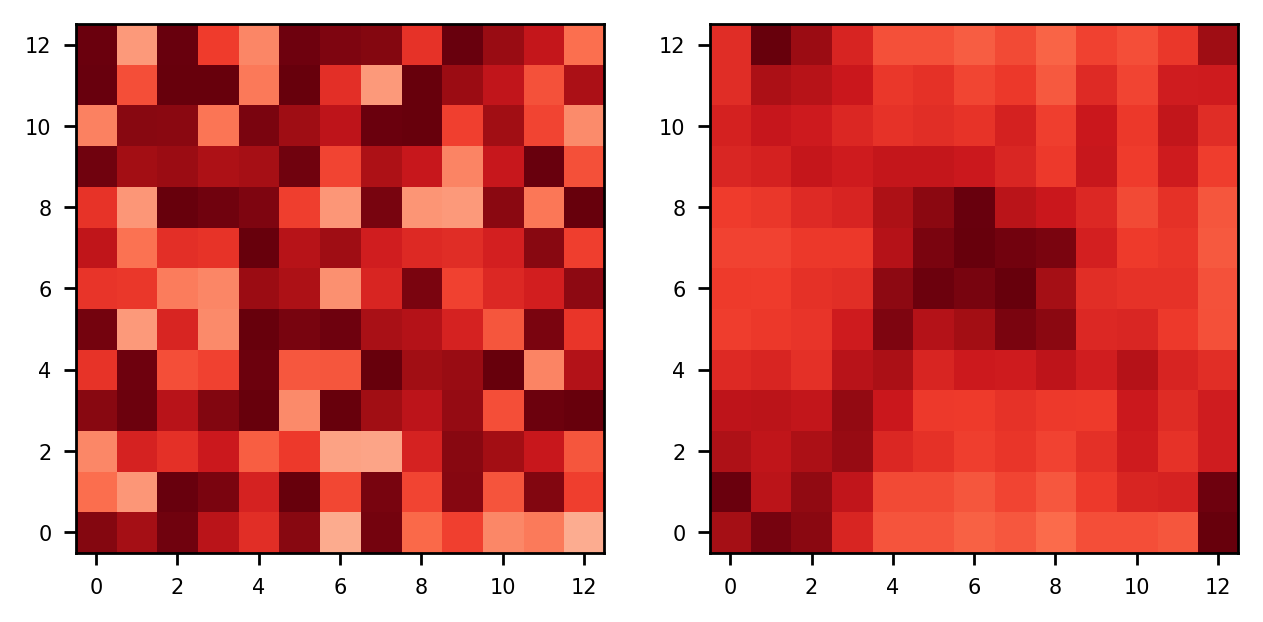

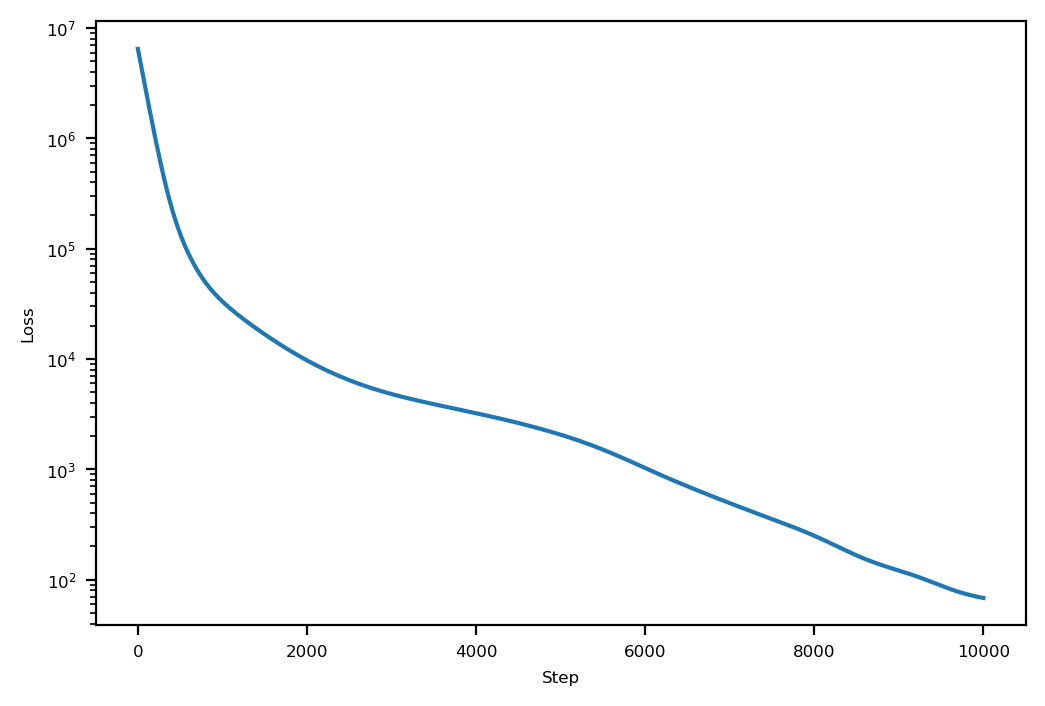

In [177]:
q0 = torch.from_numpy(qi).to(device)
c0 = torch.from_numpy(c).to(device)
m0 = torch.from_numpy(m).to(device)
theta = torch.ones_like(c0) * np.pi / 2
theta = torch.from_numpy(np.random.random([N, N])).to(device)
theta = nn.Parameter(theta, requires_grad=True)

fig, ax = plt.subplots(1, 2, dpi=250)
ax[0].imshow(np.cos(theta.detach().cpu())**2, cmap='Reds', vmin=0, vmax=1)

opt = torch.optim.Adam([theta], lr=1e-3)

best_loss = 1e10
theta_opt = None
beta = 1e-3

hist = []
for i in tqdm(range(10000)):
    opt.zero_grad()
    loss = loss_func(theta)
    loss.backward()
    hist.append(loss.item())
    if loss.item() < best_loss:
        best_loss = loss.item()
        theta_opt = theta
    opt.step()

theta = theta_opt.detach().cpu().numpy()
np.save('FPtheta_Adam', theta)
ax[1].imshow(np.cos(theta)**2, cmap='Reds', vmin=0, vmax=1)

plt.figure()
plt.plot(hist)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')

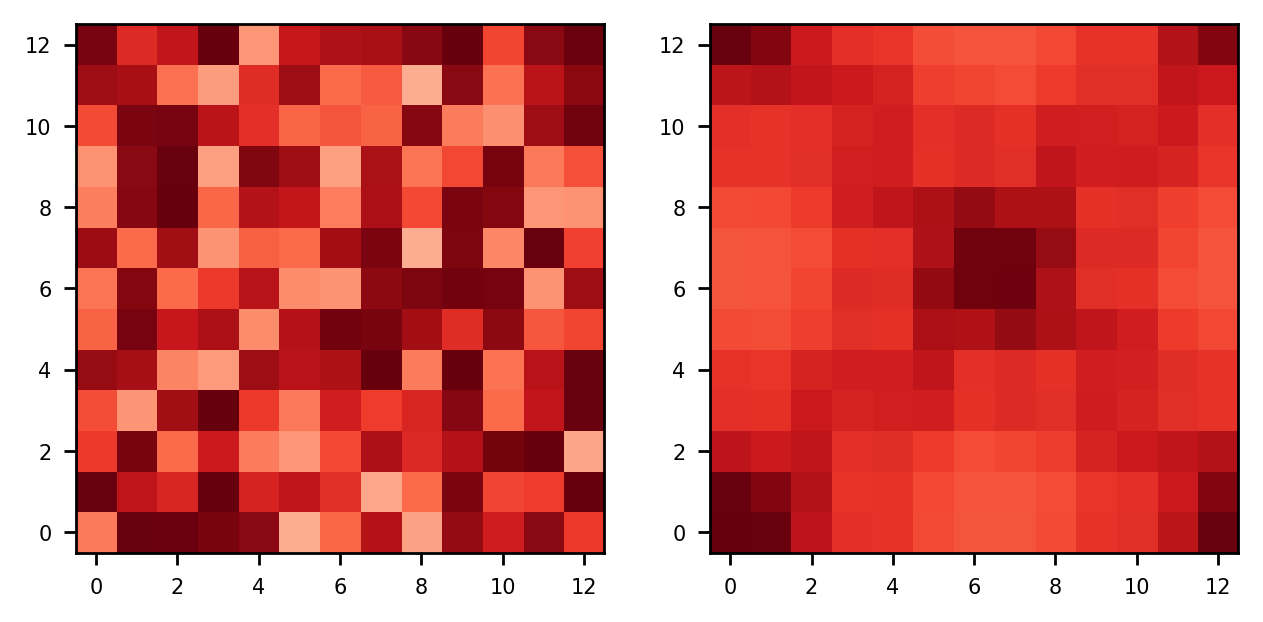

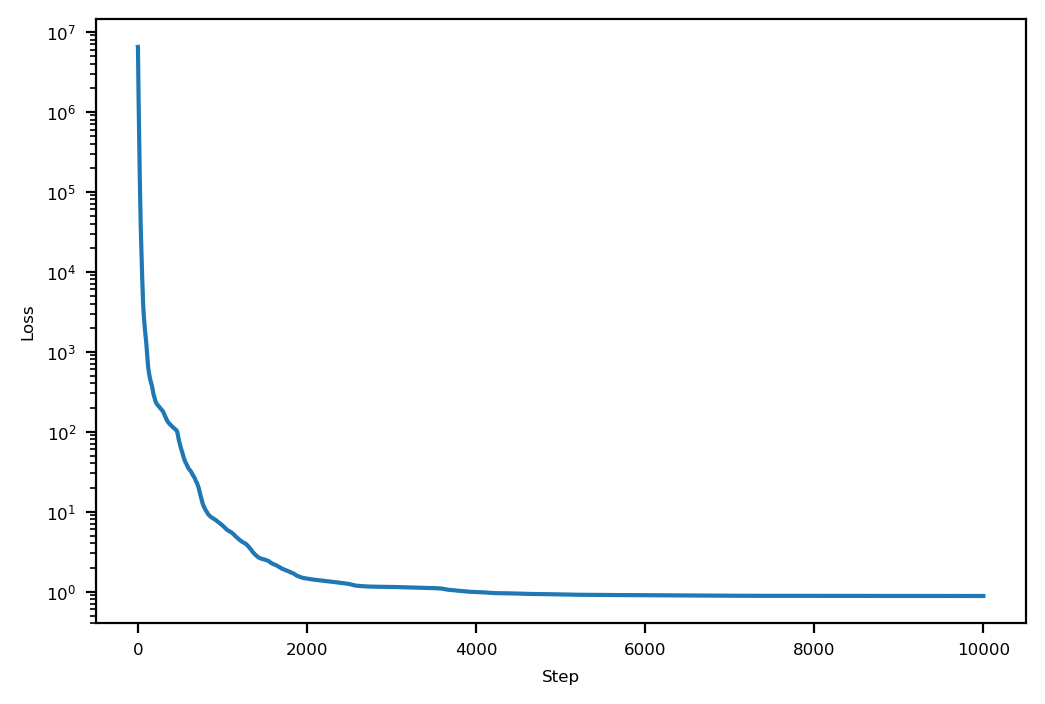

In [179]:
q0 = torch.from_numpy(qi).to(device)
c0 = torch.from_numpy(c).to(device)
m0 = torch.from_numpy(m).to(device)
theta = torch.ones_like(c0) * np.pi / 2
theta = torch.from_numpy(np.random.random([N, N])).to(device)
theta = nn.Parameter(theta, requires_grad=True)

fig, ax = plt.subplots(1, 2, dpi=250)
ax[0].imshow(np.cos(theta.detach().cpu())**2, cmap='Reds', vmin=0, vmax=1)

opt = torch.optim.LBFGS([theta], 
                        max_iter=10000,
                        lr=1e-1)
hist = []
def closure():
    opt.zero_grad()
    loss = loss_func(theta)
    loss.backward()
    hist.append(loss.item())
    return loss

opt.step(closure)
theta = theta.detach().cpu().numpy()
np.save('FPtheta_LBFGS', theta)

ax[1].imshow(np.cos(theta)**2, cmap='Reds', vmin=0, vmax=1)

plt.figure()
plt.plot(hist)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')